In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from seisfwi.model import ElasticModel
from seisfwi.survey import Survey, Source, Receiver, GenericCable, SeismicData
from seisfwi.propagator import ElasticPropagator
from seisfwi.problem import ElasticFWI, WaveformL2Loss

from seisfwi.utils import wavelet, moment_tensor, plot_data, plot_sg, timer, plot_misfit, load_misfit, smooth2d
from seisfwi.utils import generate_ellipse_anomaly, smart_cable

## Working path

In [9]:
path = './37-FWI-DAS-NS'

os.makedirs(path, exist_ok=True)

### Parameters for elastic model

In [10]:
ox = 0.0
oz = 0.0
nx = 481
nz = 81
dx = 6.25
dz = 6.25

nt = 4000
dt = 0.002
f0 = 2.0
amp = 1e7

In [11]:
# True model for modeling obs data
vp_all = np.load('../models/Marmousi2/Marmousi-Vp-13601x2801-1.25m.npy').T
vs_all = np.load('../models/Marmousi2/Marmousi-Vs-13601x2801-1.25m.npy').T
rho_all = np.load('../models/Marmousi2/Marmousi-Rho-13601x2801-1.25m.npy').T

# cut the model
vp = vp_all[370:775:5, 3000:5405:5].astype(np.float32)
vs = vs_all[370:775:5, 3000:5405:5].astype(np.float32)
rho = rho_all[370:775:5, 3000:5405:5].astype(np.float32)

In [12]:
model = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp, vs = vs, rho = rho, free_surface=True, nabc=20)  

In [13]:
model

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1540.00 -  1804.62 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :   318.80 -   530.60 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  1894.97 -  2046.59 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    481, nz =     81
  Model size: 116883
  Free surface: True
  Absorbing layers: 20

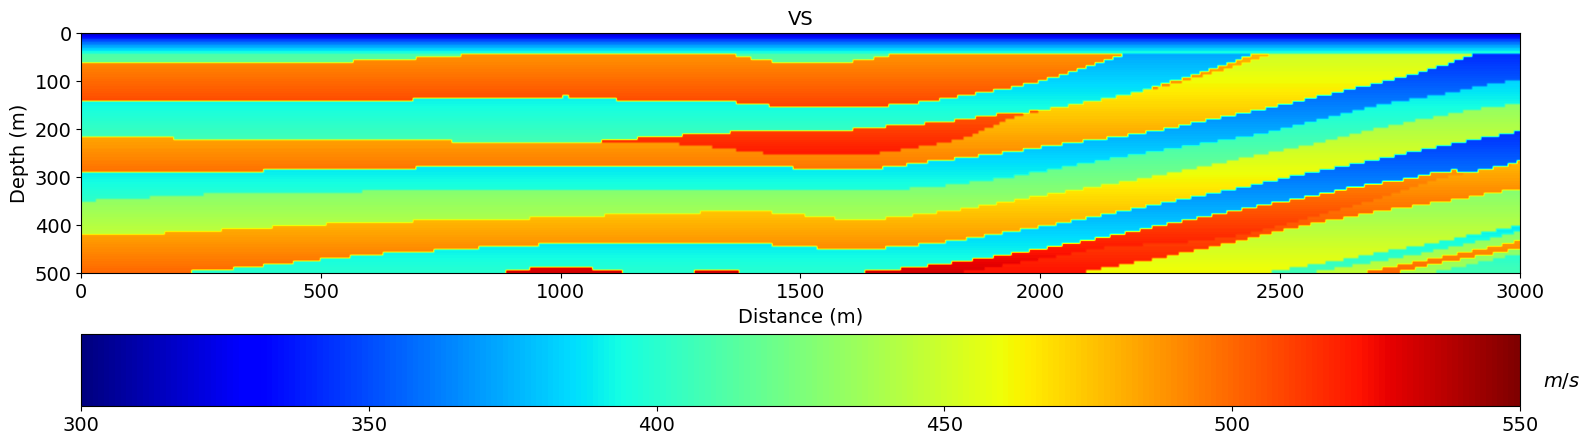

In [14]:
cmap_range = {'vp': (1500, 1850), 'vs': (300, 550), 'rho': (1850, 2100)}
model.plot(cmap_range = cmap_range, pars = ['vs'], orientation='horizontal', aspect=1)

### Initial model

In [15]:
nsmooth = 10
vp_int = smooth2d(vp, nsmooth, nsmooth)
vs_int = smooth2d(vs, nsmooth, nsmooth)
rho_int = smooth2d(rho, nsmooth, nsmooth)

# vp_int_1d = np.mean(vp_int, axis=1)
# vs_int_1d = np.mean(vs_int, axis=1)
# rho_int_1d = np.mean(rho_int, axis=1)

# # vp_int_1d = np.linspace(vp.min(), vp.max() * 0.9, num=nz)
# # vs_int_1d = np.linspace(vs.min(), vs.max() * 0.9, num=nz)
# # rho_int_1d = np.linspace(rho.min(), rho.max() * 0.9, num=nz)

# for i in range(nx):
#     vp_int[:,i] = vp_int_1d
#     vs_int[:,i] = vs_int_1d
#     rho_int[:,i] = rho_int_1d

In [16]:
model_int = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_int, vs = vs_int, rho = rho_int, free_surface=True, nabc=20)  

In [17]:
model_int

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1590.74 -  1752.83 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :   357.87 -   482.68 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  1976.52 -  2030.80 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    481, nz =     81
  Model size: 116883
  Free surface: True
  Absorbing layers: 20

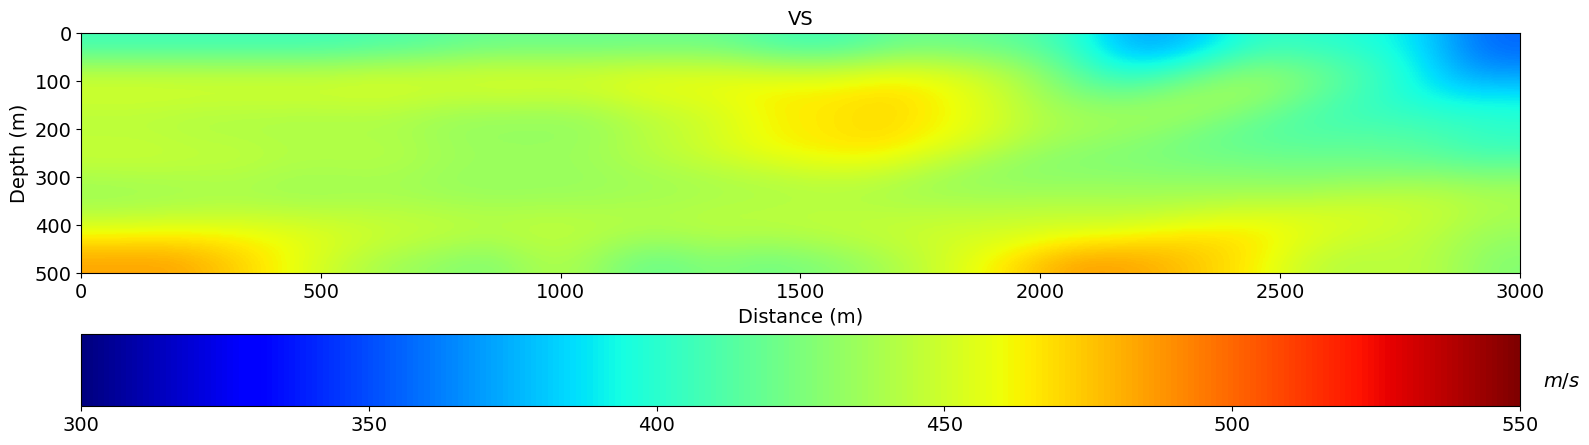

In [18]:
model_int.plot(cmap_range = cmap_range, pars = ['vs'], orientation='horizontal', aspect=1)

### Gradient Mask

In [13]:
# set the gradient mask to exclude the water layers
nmask = 0
grad_mask = np.ones_like(vp)
grad_mask[:nmask, :] = 0
# grad_mask[nmask:nmask+10, :] = np.flip(np.repeat(np.linspace(0, 1, 10), nx).reshape(10, nx))

### Source

In [14]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

# # Set source attributes
for isrc in range(23):
    source.add_source([125 * isrc + 125, dx], wvlt, 'vz')

source

Seismic Source:
  Source wavelet: 4000 samples at 2.00 ms
  Source number : 23
  Source types  : ['vz']
  Source x range: 125.00 - 2875.00 m
  Source z range:   6.25 -   6.25 m

## Geophone Inversion

In [15]:
geophone = Receiver(nt = nt, dt = dt)
for irec in range(nx-2):
    geophone.add_receiver([dx * (irec + 1), dx], 'vx')
    geophone.add_receiver([dx * (irec + 1), dx], 'vz')

In [16]:
survey = Survey(source=source, receiver=geophone, device='cuda', gpu_num=4, reciprocity=False, simultaneous=False, interpolation=False)

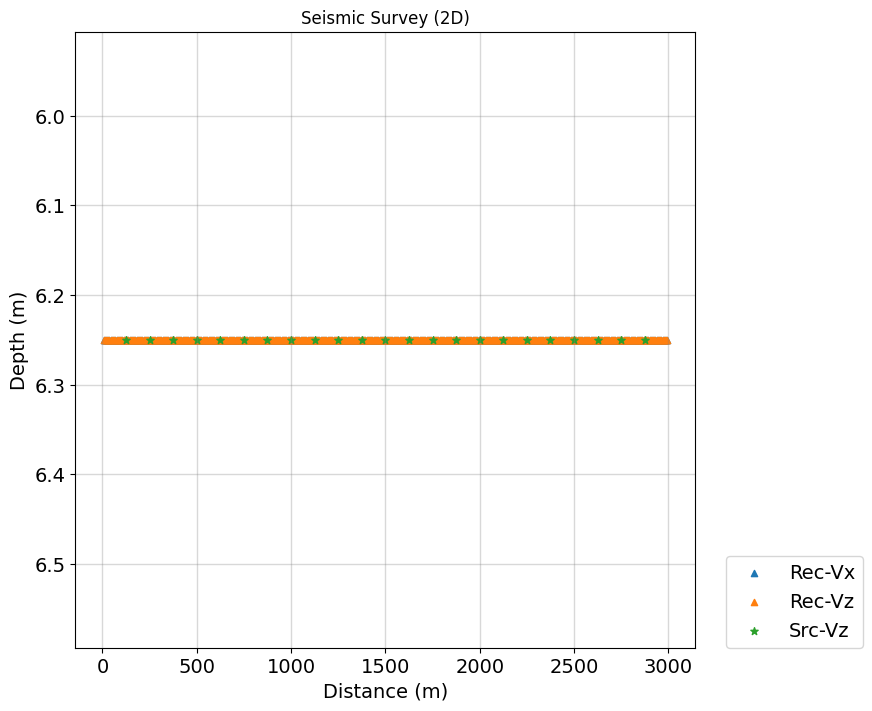

In [17]:
survey.plot()

In [18]:
F = ElasticPropagator(model, survey)

Survey analysis completed: legal survey
free surface: True


In [19]:
dobs = F()

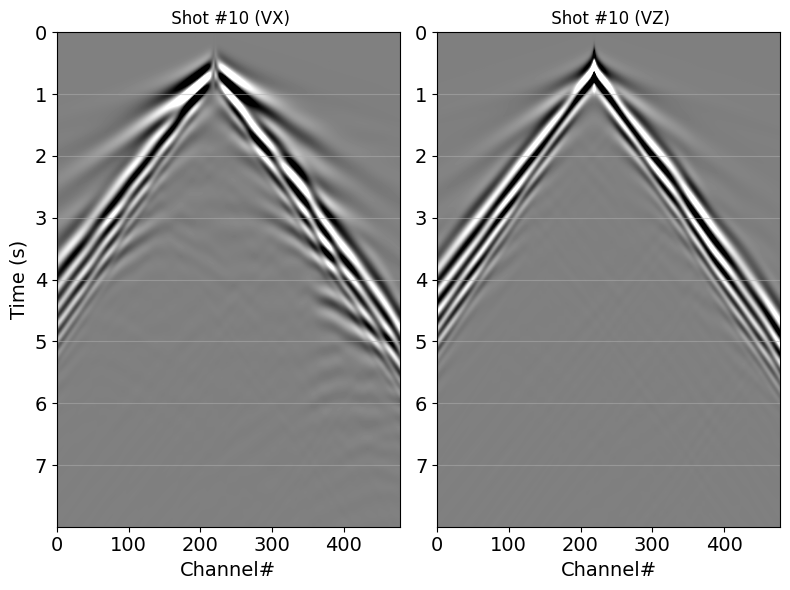

In [20]:
dobs.plot(shotid=10, comp=['vx', 'vz'], clip=99.)

In [21]:
model_fwi = ElasticModel(ox, oz, dx, dz, nx, nz,
                     vp = vp_int, 
                     vs = vs_int, 
                     rho = rho_int, 
                     vp_grad = False, 
                     vs_grad = True,
                     rho_grad = False,
                     vp_bound = [500, 2000],
                     vs_bound = [200, 600],
                     rho_bound = [1400, 2200],
                     free_surface=True, 
                     nabc=20,
                     mask = grad_mask)

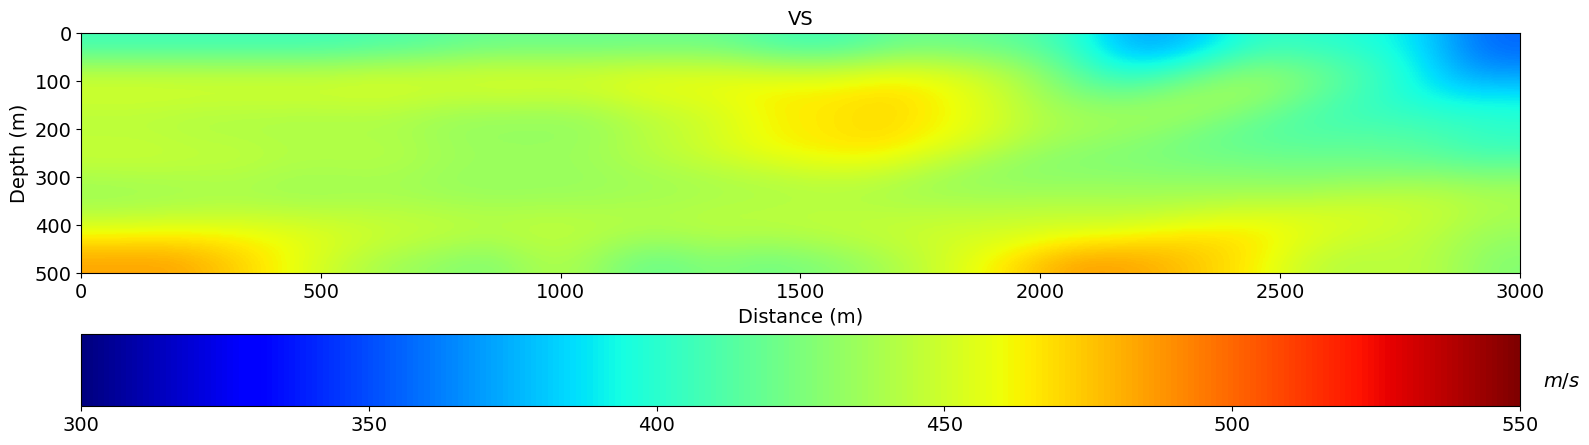

In [22]:
model_fwi.plot(cmap_range = cmap_range, pars = ['vs'], orientation='horizontal', aspect=1)

In [23]:
model_int = ElasticModel.clone(model_fwi)
dsyn_int = F(model_int)

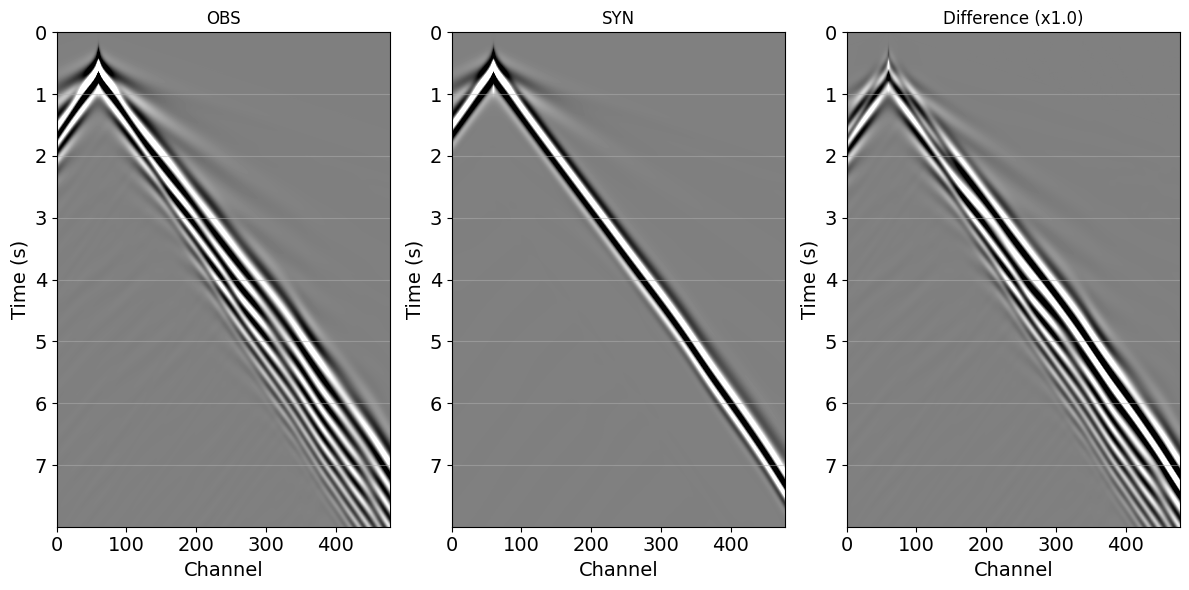

In [24]:
dobs.plot_compare(dsyn_int, shotid=2, comp='vz', clip=98, title=['OBS', 'SYN', 'Difference'], save_path=path + '/data-compare-int.png')

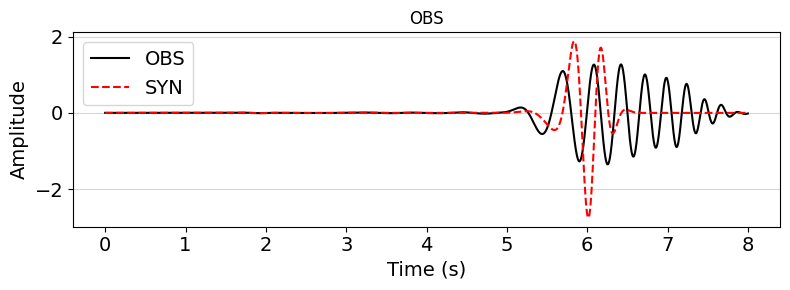

In [25]:
dobs.plot_compare_trace(dsyn_int, shotid=2, comp='vz', traceid=400, title=['OBS', 'SYN'], linestyle = ['k-', 'r--'], save_path = path + '/trace-int.png')

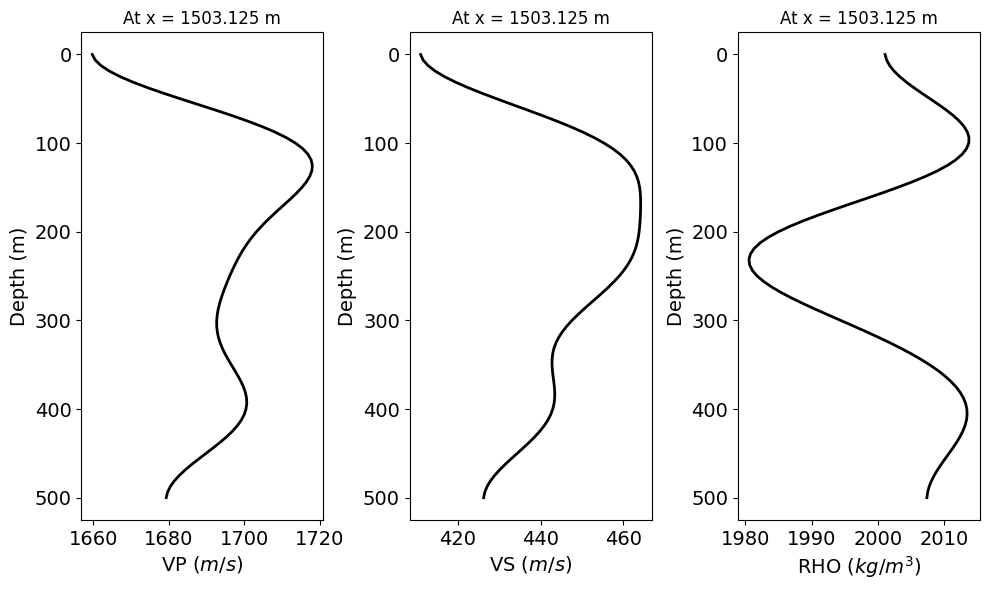

In [26]:
model_fwi.plot_well_log()

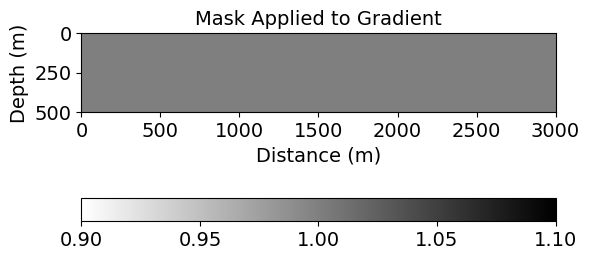

In [27]:
model_fwi.plot_mask()

In [28]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi.parameters(), lr = 1.0, max_iter = 50, tolerance_change = 1e-4, history_size = 5, line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 'vz': 1.0}

In [29]:
fwi = ElasticFWI(F, model_fwi, optimizer, misfit, dobs, weight)

In [30]:
fwi(nshot_per_gpu_per_batch = 8, max_iter = 2, grad_scale = 20.0, grad_interval=2)

FWI: evaluating initial model ...
**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         50
***********************************************************

   Niter           fk                ngrad          max grad
     1       4.039807e+04                1         2.15e-01
     1       4.039559e+04                1         2.15e-01
     1       4.036837e+04                1         2.15e-01
     1       4.009688e+04                1         2.14e-01
     1       3.745681e+04                1         2.10e-01
     1       2.189111e+04                1         1.84e-01
     2       2.000632e+04                7         3.43e-01
     3       1.885888e+04                8         3.33e-01
     4       1.658955e+04                9         2.65e-01
     5       1.476066e+04               10        

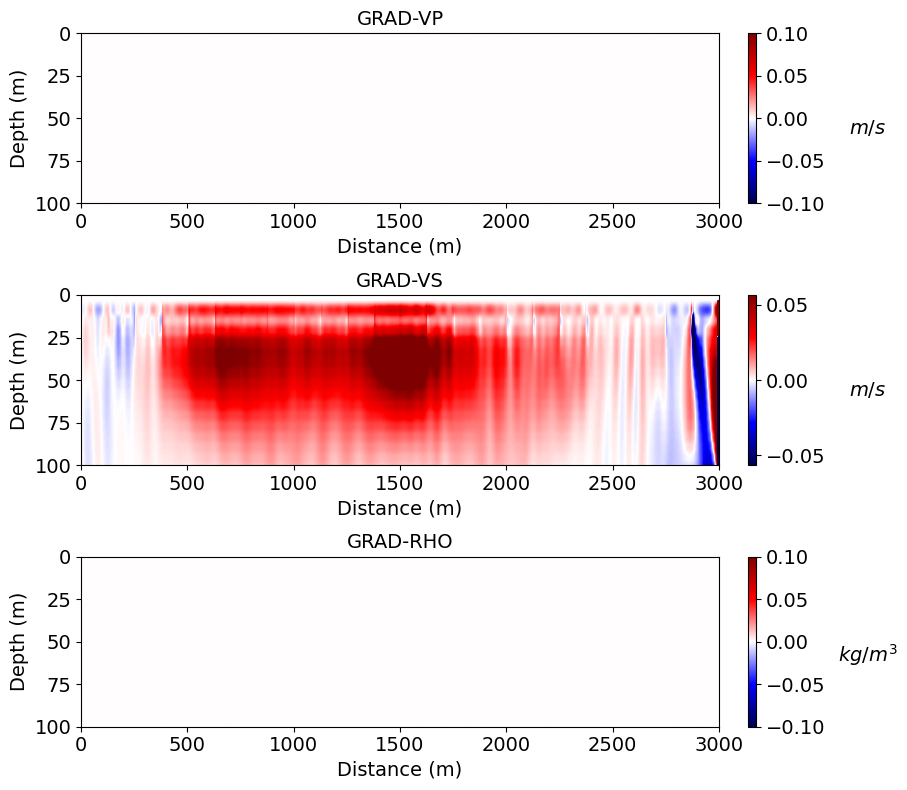

In [31]:
model_fwi.plot(grad=True, cmap='seismic', clip=99.0 , zlim=[0, 100], aspect=8, orientation = 'vertical',)

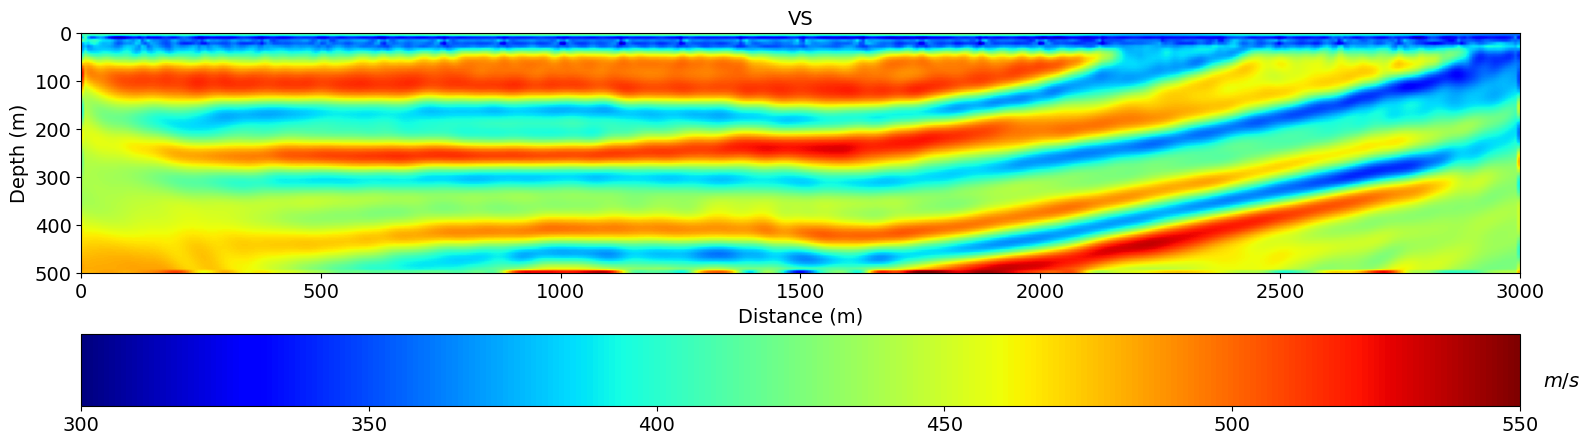

In [32]:
model_fwi.plot(cmap_range = cmap_range, pars = ['vs'], orientation='horizontal', aspect=1)

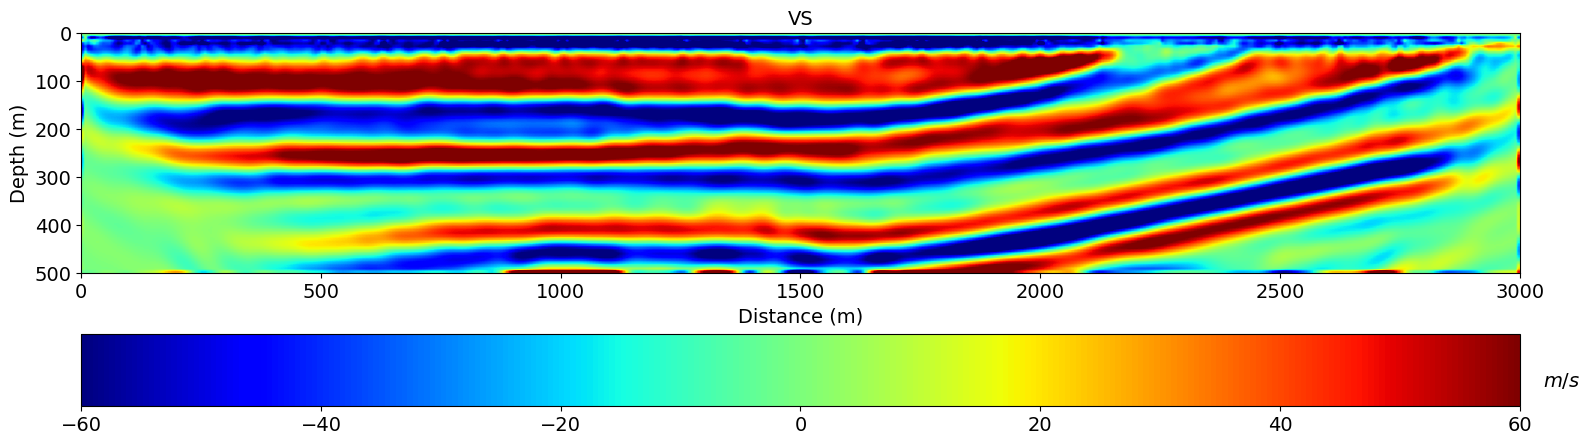

In [33]:
update_cmap_range = {'vp': (-1, 1), 'vs': (-60, 60), 'rho': (-20, 20)}

(model_fwi- model_int).plot(cmap_range = update_cmap_range, pars=['vs'], cmap='jet', orientation = 'horizontal')

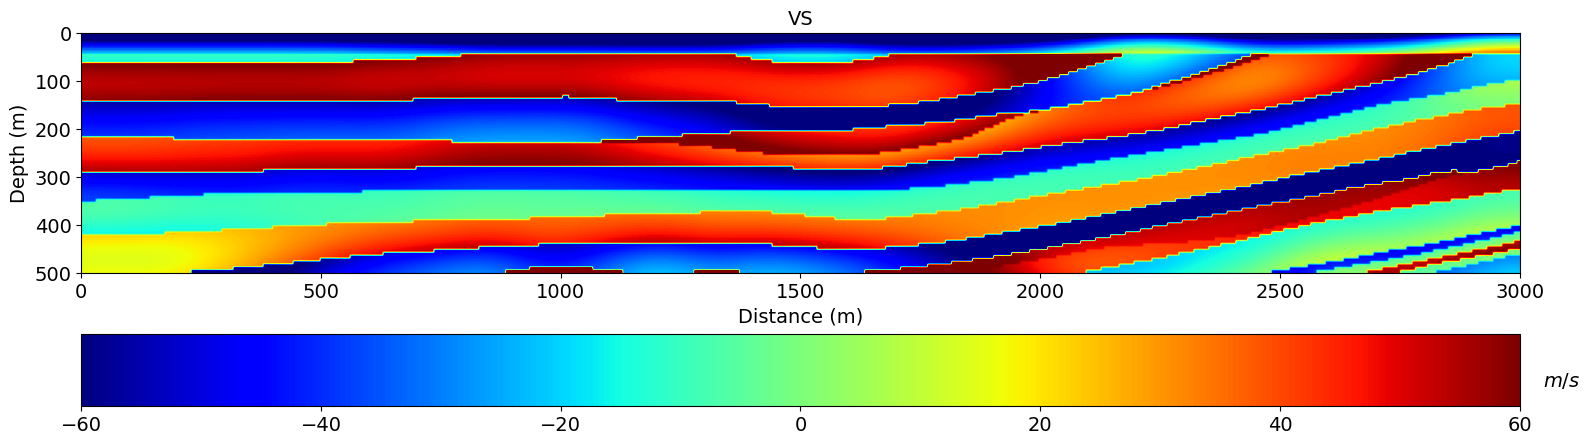

In [34]:
(model- model_int).plot(cmap_range = update_cmap_range, pars=['vs'], cmap='jet', orientation = 'horizontal')

In [35]:
model_final = ElasticModel.clone(model_fwi)
dsyn_fwi = F(model_final)

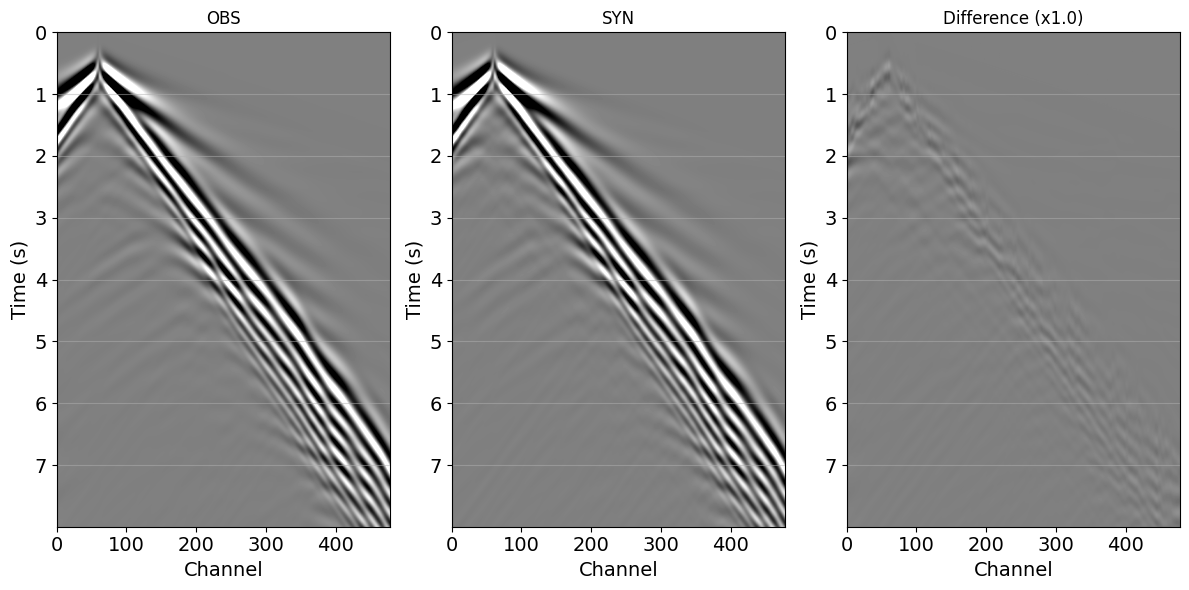

In [36]:
dobs.plot_compare(dsyn_fwi, shotid=2, comp='vx', clip=98, title=['OBS', 'SYN', 'Difference'], save_path=path + '/data-compare-fwi.png')

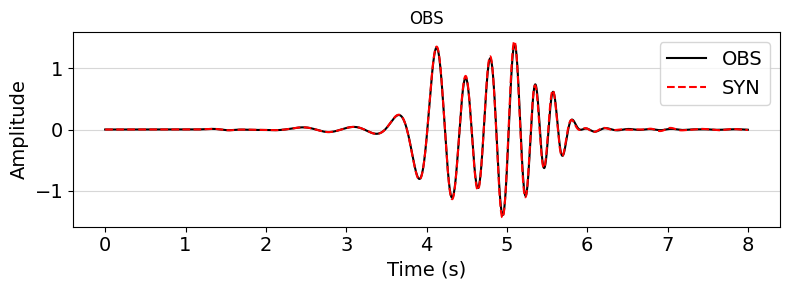

In [37]:
dobs.plot_compare_trace(dsyn_fwi, shotid=2, comp='vz', traceid=300, title=['OBS', 'SYN'], linestyle = ['k-', 'r--'], save_path = path + '/trace-FWI.png')

In [42]:
model_fwi.save(path + '/model_fwi_geophone')

In [19]:
model_fwi_geo = ElasticModel.from_file(path + '/model_fwi_geophone.npz')
model_fwi_das = ElasticModel.from_file(path + '/model_fwi_das.npz')
model_fwi_das_smart = ElasticModel.from_file(path + '/model_fwi_das_smart.npz')

Model loaded from file: ./37-FWI-DAS-NS/model_fwi_geophone.npz
Model loaded from file: ./37-FWI-DAS-NS/model_fwi_das.npz
Model loaded from file: ./37-FWI-DAS-NS/model_fwi_das_smart.npz


In [20]:
vs_all = [
    model.get_model('vs'),
    model_int.get_model('vs'),
    model_fwi_das.get_model('vs'),
    model_fwi_das_smart.get_model('vs'),
    model_fwi_geo.get_model('vs'),]

/tmp/ipykernel_48743/118789156.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


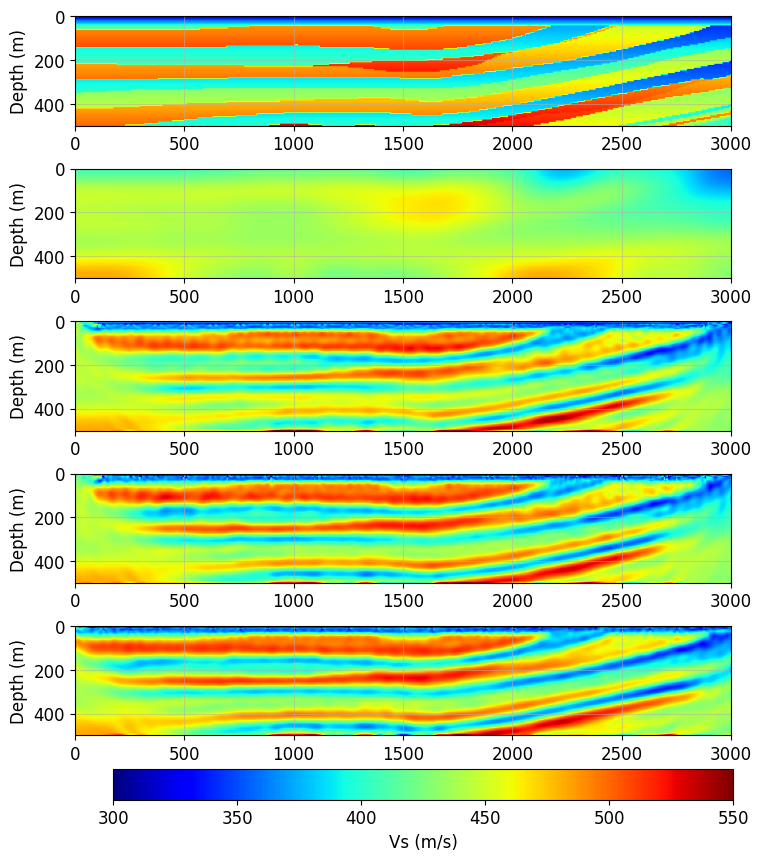

In [21]:
fontsize = 12
plt.rcParams.update(
    {
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize,
    }
)

vmin = 300
vmax = 550
aspect = 1
cmap = 'jet'
fig = plt.figure(figsize=(16, 10))

extent = [model.x[0], model.x[-1], model.z[-1], model.z[0]]

# Store the first image to associate with the colorbar
first_image = None

for i, vs in enumerate(vs_all):
    ax = fig.add_subplot(len(vs_all), 1, i + 1)
    img = ax.imshow(vs, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    if i == 0:
        first_image = img  # Store the first image
    ax.grid(alpha=0.5)
    if i == 4:
        ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Depth (m)")
    ax.set_aspect(aspect)

# Create a colorbar associated with the first image
cbar = fig.colorbar(first_image, ax=fig.axes, orientation='horizontal', shrink=0.5, pad=-0.4)
cbar.set_label('Vs (m/s)')  # Set the label for the colorbar
plt.tight_layout()
plt.savefig(path + '/result.png', dpi=300, bbox_inches='tight')
plt.show()


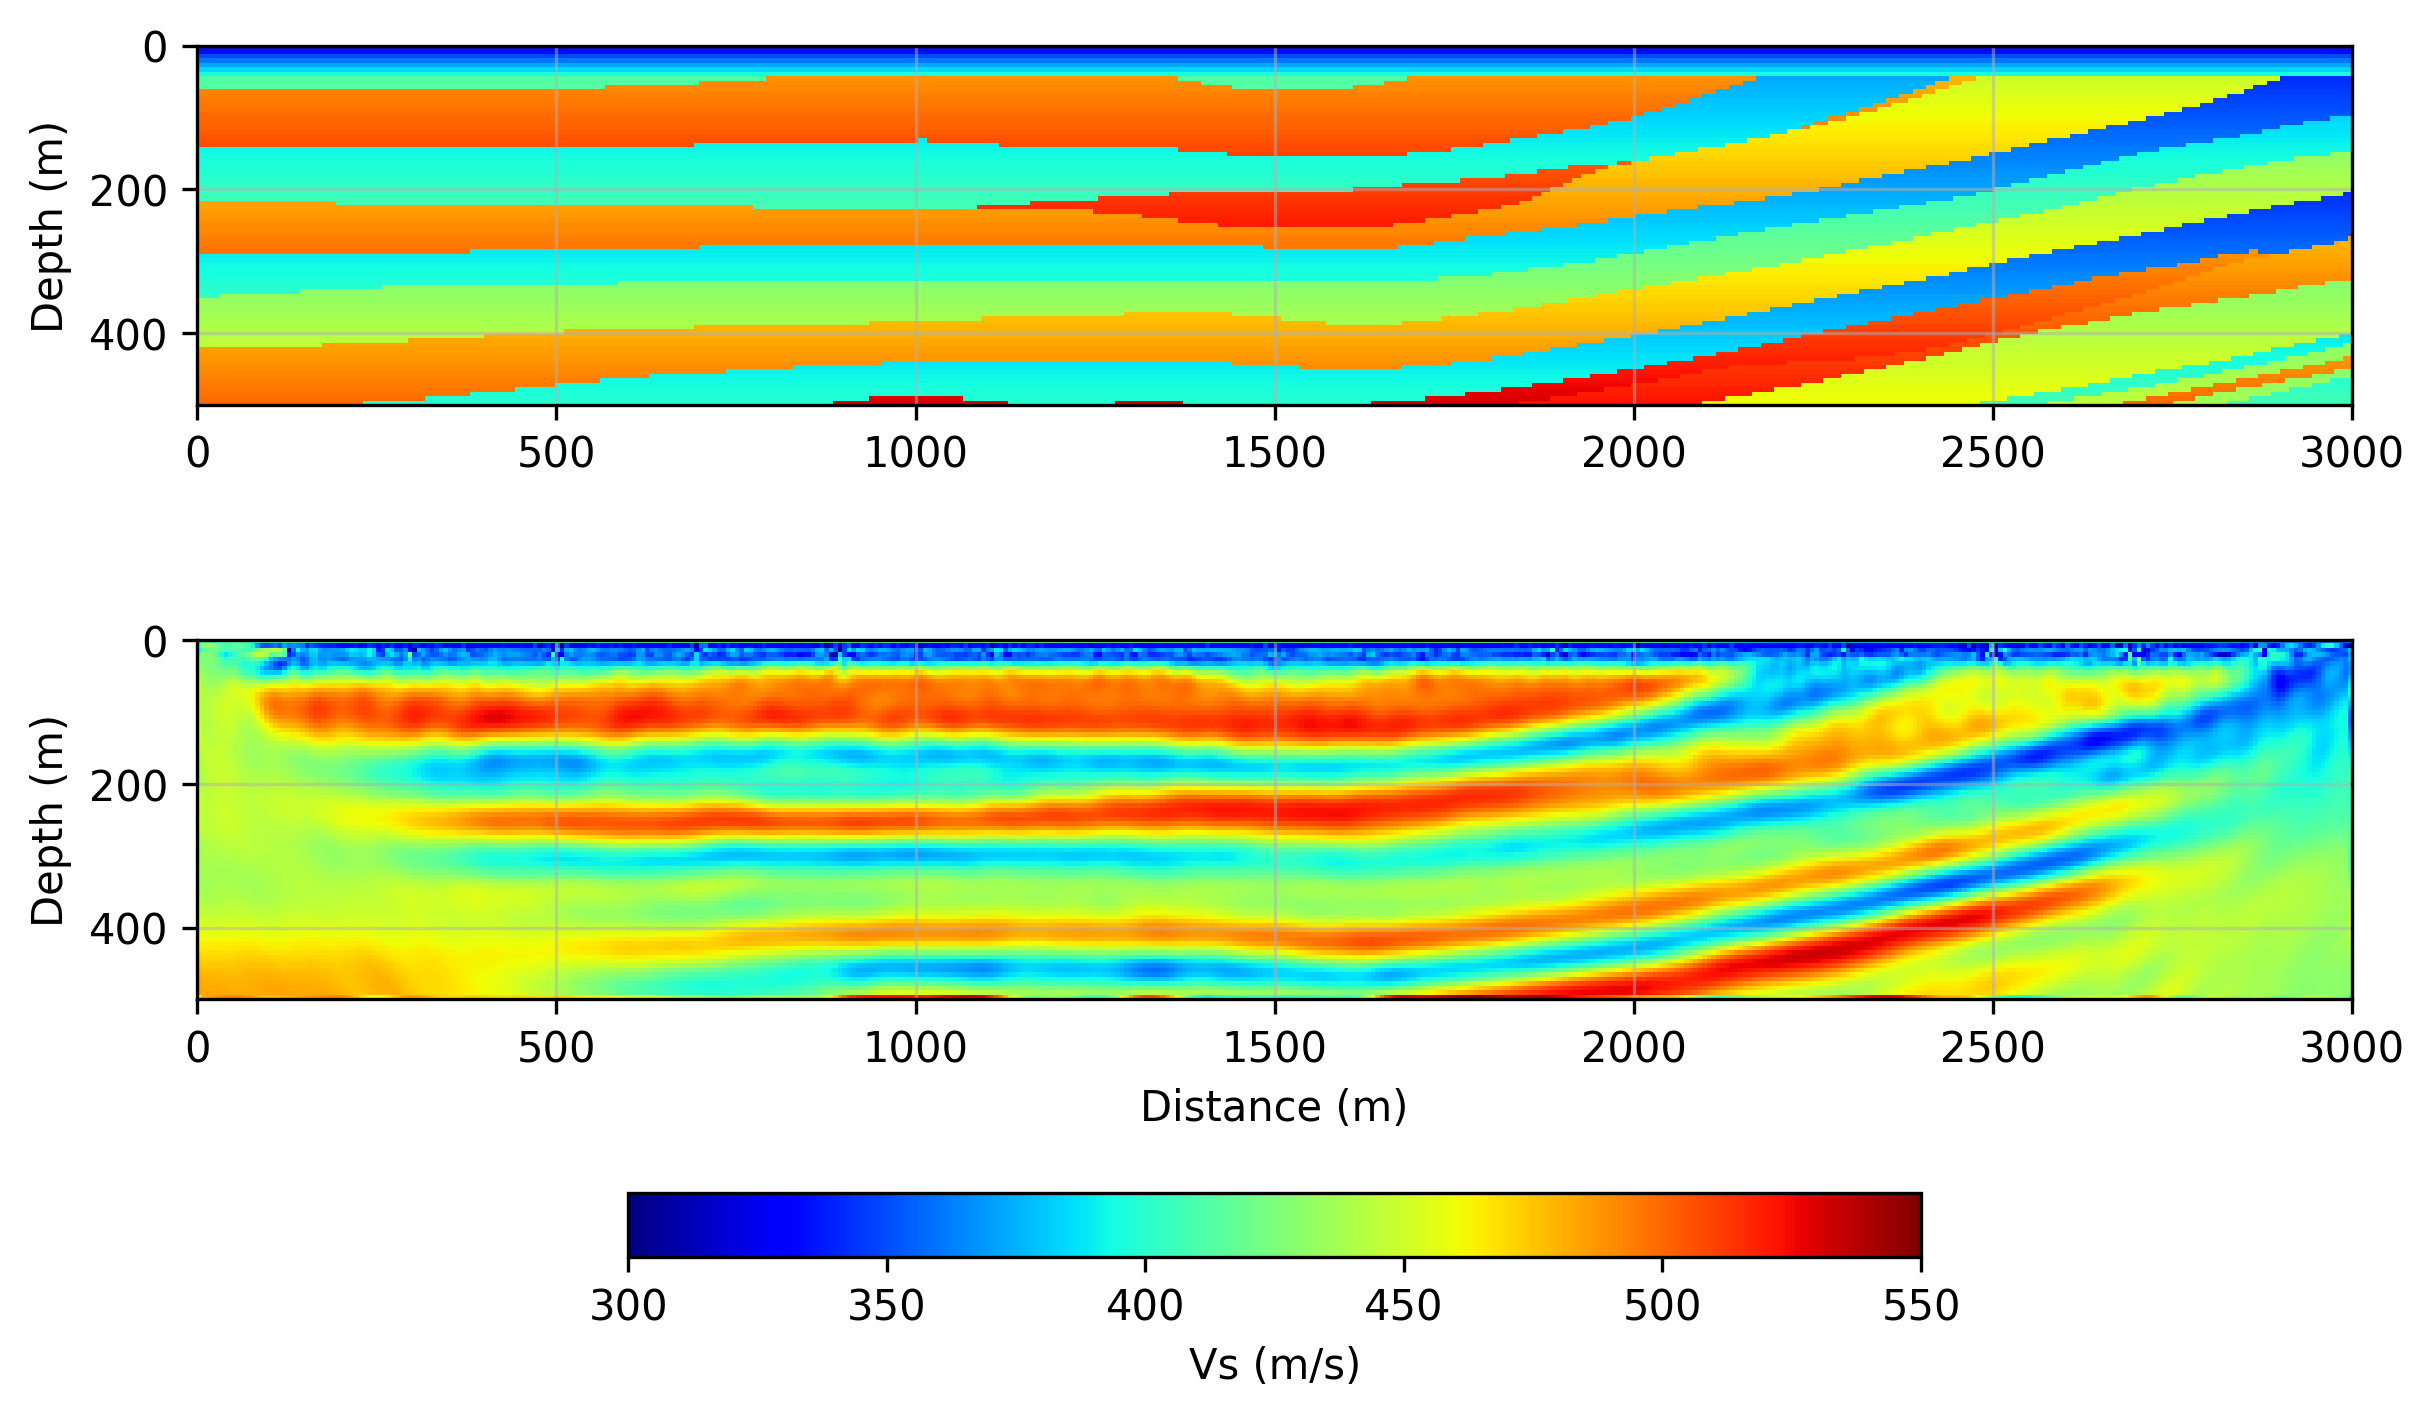

In [45]:
fontsize = 10
plt.rcParams.update(
    {
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize,
    }
)

vmin = 300
vmax = 550
aspect = 1
cmap = 'jet'
fig = plt.figure(figsize=(8, 5), dpi=300, constrained_layout=True)

extent = [model.x[0], model.x[-1], model.z[-1], model.z[0]]

# Store the first image to associate with the colorbar
first_image = None

vs_all = [
    model.get_model('vs'),
    model_fwi_das_smart.get_model('vs'),
]

for i, vs in enumerate(vs_all):
    ax = fig.add_subplot(len(vs_all), 1, i + 1)
    img = ax.imshow(vs, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    if i == 0:
        first_image = img  # Store the first image
    ax.grid(alpha=0.5)
    if i == 1:
        ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Depth (m)")
    ax.set_aspect(aspect)

# Create a colorbar associated with the first image
cbar = fig.colorbar(first_image, ax=fig.axes, orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('Vs (m/s)')  # Set the label for the colorbar
plt.savefig(path + '/result.png', dpi=300, bbox_inches='tight')
plt.show()

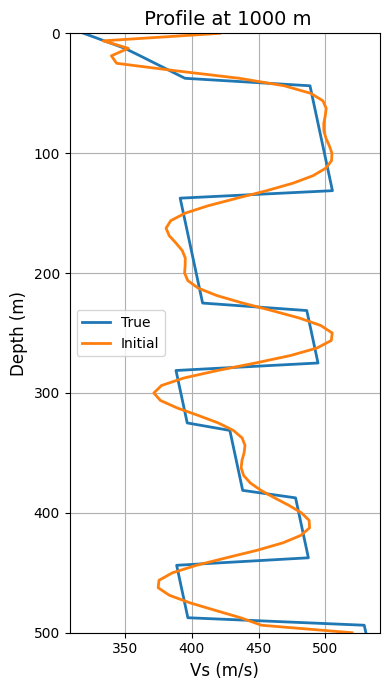

In [24]:
plt.figure(figsize=(4, 7))  # Increased size and resolution
label = ['True', 'Initial', 'FWI-DAS', 'FWI-Smart-DAS', 'FWI-GEO']
depth = np.linspace(0, 500, nz)
for i, vs in enumerate(vs_all):
    plt.plot(vs[:, 160], depth, label=label[i], linewidth=2)  # Increased linewidth

plt.ylim([0, 500])
plt.legend(fontsize=10)  # Increased font size for legend
plt.gca().invert_yaxis()
plt.xlabel('Vs (m/s)', fontsize=12)  # Added x-axis label
plt.ylabel('Depth (m)', fontsize=12)  # Added y-axis label
plt.title(' Profile at 1000 m', fontsize=14)  # Added title
plt.grid(True)  # Added grid
plt.tick_params(axis='both', which='major', labelsize=10)  # Adjusted tick parameters
plt.tight_layout()
plt.savefig(path + '/result-1d.png', dpi=300, bbox_inches='tight')
plt.show()


In [48]:
vs.shape

(81, 481)